# Data Import and Setup
This section imports essential libraries for data manipulation, visualization, and file handling.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

**Country Title Mapping**

The dictionary good_title maps country abbreviations to full names. This will be useful for visualizations or reports where country names need to be displayed clearly.

In [3]:
good_title = {
    'Brazil': 'Brazil',
    'Turkey': 'Turkey',
    'USA': 'USA',
    'India': 'India',
    'Japan': 'Japan',
    'Portugal': 'Portugal',
    'Nigeria': 'Nigeria'
}

In this step, Google Drive is mounted to access the dataset stored in your Google Drive account or feel free to skip this if you're doing it locally

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
root_dir = '/content/drive/MyDrive/image-transcreation/part3-image_assessment'
countries = sorted([x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x)) if x!='labels'])

In [8]:
countries

['Brazil', 'India', 'Japan', 'Nigeria', 'Portugal', 'Turkey', 'USA']

Preparing the data dictionary-wise for each country

In [19]:
def get_dicts(df1, df2, gold_labels, q1=False):

  q1_df1 = df1.replace({'[a-z\(\)\s]': ''}, regex=True) # Remove unneccessary text
  if q1:
    q1_df1.columns = ['1','2', '3', '4'] # Replace column names with Image Numbers
  else:
    q1_df1.columns = ['2', '3', '4']

  q1_df2 = df2.replace({'[a-z\(\)\s]': ''}, regex=True) # Remove unneccessary text
  if q1:
    q1_df2.columns = ['1','2', '3', '4'] # Replace column names with Image Numbers
  else:
    q1_df2.columns = ['2', '3', '4']

  if q1:

    class_dict_1_df1 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df1.keys():
        class_dict_1_df1[label].extend(q1_df1.iloc[:,1:][gold_labels == label].stack().values)

    class_dict_1_df2 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df2.keys():
        class_dict_1_df2[label].extend(q1_df2.iloc[:,1:][gold_labels == label].stack().values)

    class_dict_1_df1['original'] = q1_df1.iloc[:,0].values
    class_dict_1_df2['original'] = q1_df2.iloc[:,0].values

  else:

    class_dict_1_df1 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df1.keys():
        class_dict_1_df1[label].extend(q1_df1[gold_labels == label].stack().values)

    class_dict_1_df2 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df2.keys():
        class_dict_1_df2[label].extend(q1_df2[gold_labels == label].stack().values)

  return class_dict_1_df1, class_dict_1_df2

In [21]:
# Merge 5 split csvs into one dataframe.


def merge_country_splits(Country):

  # Initialize lists to hold dataframes for concatenation
  all_df1 = []
  all_gold_df = []
  all_gold_df_temp = []

  # Loop over the 5 splits
  for split_num in range(1, 6):
      # Adjust the file paths for each split
      split_filename = f'/content/drive/MyDrive/image-transcreation/part3-image_assessment/{Country}/split{split_num}.csv'
      label_filename = f'/content/drive/MyDrive/image-transcreation/part3-image_assessment/labels/{Country}/split_{split_num}.csv'

      # Read the data
      df1 = pd.read_csv(split_filename)
      gold_df = pd.read_csv(label_filename)

      # Process df1
      df1 = df1.loc[2:].reset_index(drop=True)

      # Process df1 for questions, assuming similar processing as before
      df1 = df1.iloc[2:,:21]
      df1.index = df1.index - 2
      df1 = df1.head(len(gold_df))

      if gold_df.shape[0]>df1.shape[0]:
        gold_df = gold_df.head(len(df1))

      # Create and apply the boolean mask
      mask = df1.isna().any(axis=1)
      df1_filtered = df1[~mask]

      gold_df = gold_df[~mask]

      # Process gold_labels from gold_df
      gold_labels = gold_df.iloc[:,4:8]
      gold_labels.columns = ['2','3','4']

      df1_filtered.columns = [str(x) for x in range(len(df1_filtered.columns))]

      # Append the processed dataframes to their respective lists
      all_df1.append(df1_filtered)
      all_gold_df.append(gold_labels)

  # Concatenate all dataframes in each list
  concatenated_df1 = pd.concat(all_df1, ignore_index=True)
  concatenated_gold_df = pd.concat(all_gold_df, ignore_index=True)

  # print(concatenated_df1.shape, concatenated_gold_df.shape)


  return (concatenated_df1, concatenated_gold_df)



# PART 1

Analysis for concept dataset

In [23]:

idxs = [(1,4), (4,7), (7,10), (10,13), (13,17), (17,21)]

country_dicts = {}
diff_dicts = {}

for idx, country in enumerate(countries):

  country_files = glob.glob(os.path.join(root_dir, country, '*.csv'))
  country_files = [file for file in country_files if 'Stories' not in os.path.basename(file) and 'Education' not in os.path.basename(file)]

  col_idx = 22
  df1, gold_labels =  merge_country_splits(country)
  df2, gold_labels =  merge_country_splits(country)

  average_dicts = []
  q4_1 = []
  q4_2 = []
  diff_dict = {}

  q4_1_dict = {}
  q4_2_dict = {}

  for q_idx in range(6):

    q1_label = False

    if q_idx not in [0,1,2,3]:
      q1_label = True


    df1_dict, df2_dict = get_dicts(df1.iloc[:, idxs[q_idx][0]:idxs[q_idx][1]], df2.iloc[:, idxs[q_idx][0]:idxs[q_idx][1]], gold_labels, q1_label)

    average_dict = {}

    for key in df1_dict:
        # print(key)
        avg_values = []
        dict_1 = []
        dict_2 = []
        for df_idx, (val1, val2) in enumerate(zip(df1_dict[key], df2_dict[key])):
          if np.isnan(float(val1)) and np.isnan(float(val2)):\
            continue
          elif np.isnan(float(val1)):\
            avg_values.append(int(val2))
          elif np.isnan(float(val2)):\
            avg_values.append(int(val1))
          else:
            avg_values.append(int(np.floor(np.mean([int(val1), int(val2)]))))

            if q_idx==4:
              dict_1.append(max(int(val1)-int(df1_dict['original'][df_idx]),-1)) # Difference with Original Value
              dict_2.append(max(int(val2)-int(df2_dict['original'][df_idx]),-1))

        if q_idx==4:
          q4_1_dict[key] = dict_1
          q4_2_dict[key] = dict_2

        average_dict[key] = avg_values


    average_dicts.append(average_dict)

  for key in q4_1_dict.keys(): # For cultural relevance difference
    diff_dict[key] = [int(np.floor(np.mean([x,y]))) for x,y in zip(q4_1_dict[key],q4_2_dict[key])]


  diff_dicts[country] = diff_dict
  country_dicts[country] = average_dicts



In [24]:
country_dicts.keys()

dict_keys(['Brazil', 'India', 'Japan', 'Nigeria', 'Portugal', 'Turkey', 'USA'])

## Visual Changes - Q1

*There are visual changes in the generated image, when compared with the source (top-most) image.*

*1 → no visual change; 5 → high visual changes*

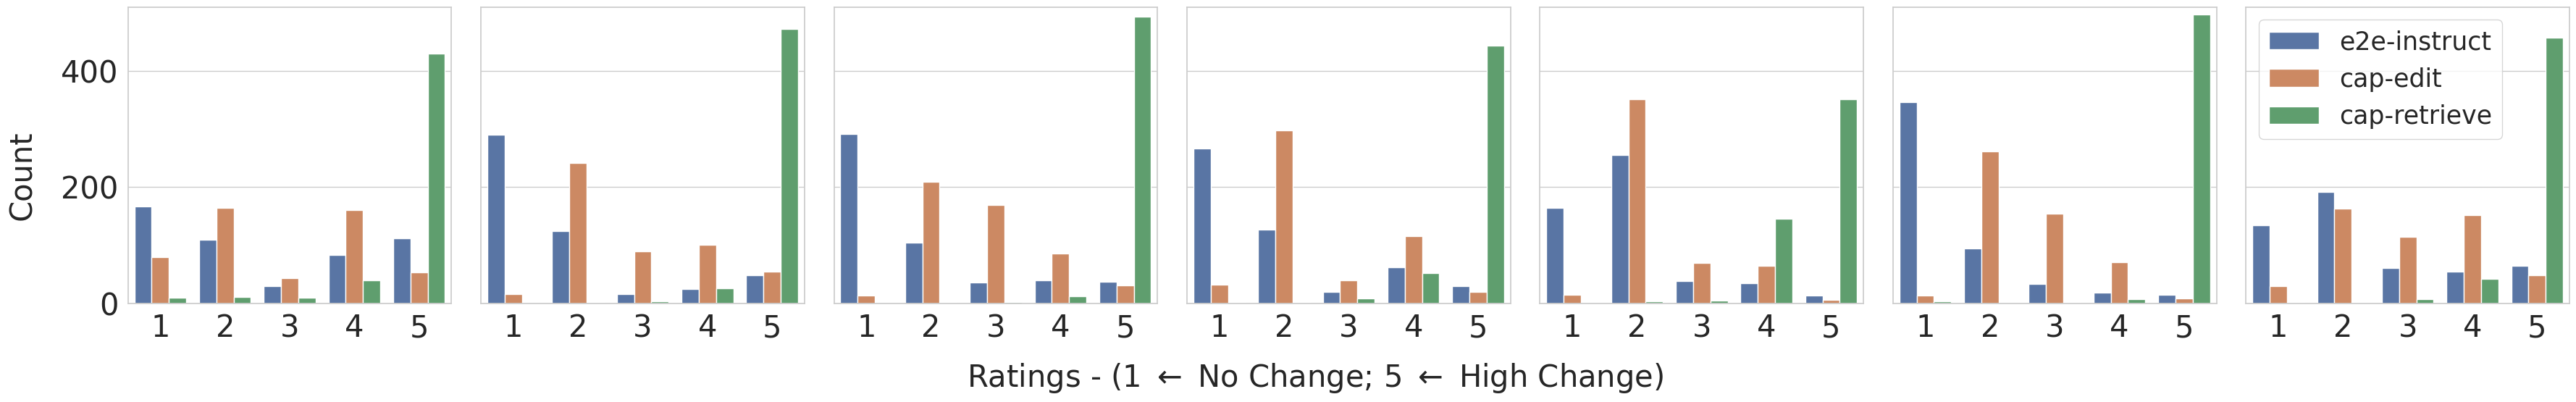

In [ ]:
sns.set(style="whitegrid")

font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][0])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].tick_params(axis='x', labelsize=30)
    axes[i].tick_params(axis='y', labelsize=30)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label
    axes[i].set_ylim(bottom=0, top=510)

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=25, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

fig.text(0.5, -0.06, 'Ratings - (1 $\leftarrow$ No Change; 5 $\leftarrow$ High Change)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Spatial Changes - Q3

*The image is from the same category (like food, beverage, flower etc.) as the source (top-most) image.*

*1 → dissimilar category; 5 → same category*

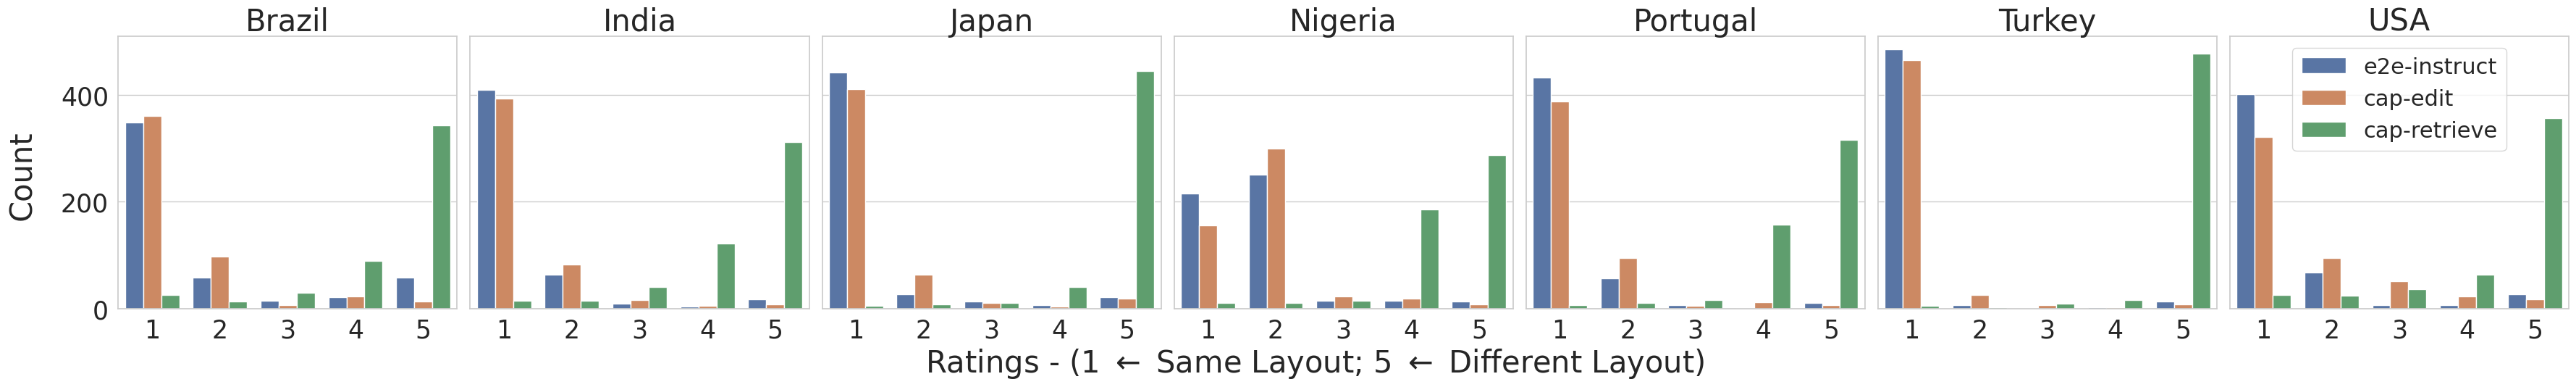

In [ ]:
sns.set(style="whitegrid")

# Assuming average_dicts is a list of dictionaries
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][2])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    replacement_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

    long_df = long_df.replace(replacement_map)

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].set_title(good_title[titles[i]], fontsize=font_size)  # Set individual title
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=22, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.02, 'Ratings - (1 $\leftarrow$ Same Layout; 5 $\leftarrow$ Different Layout)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Semantic Meaning - Without Filtering

*The image is from the same category (like food, beverage, flower etc.) as the source (top-most) image.*

*1 → dissimilar category; 5 → same category*

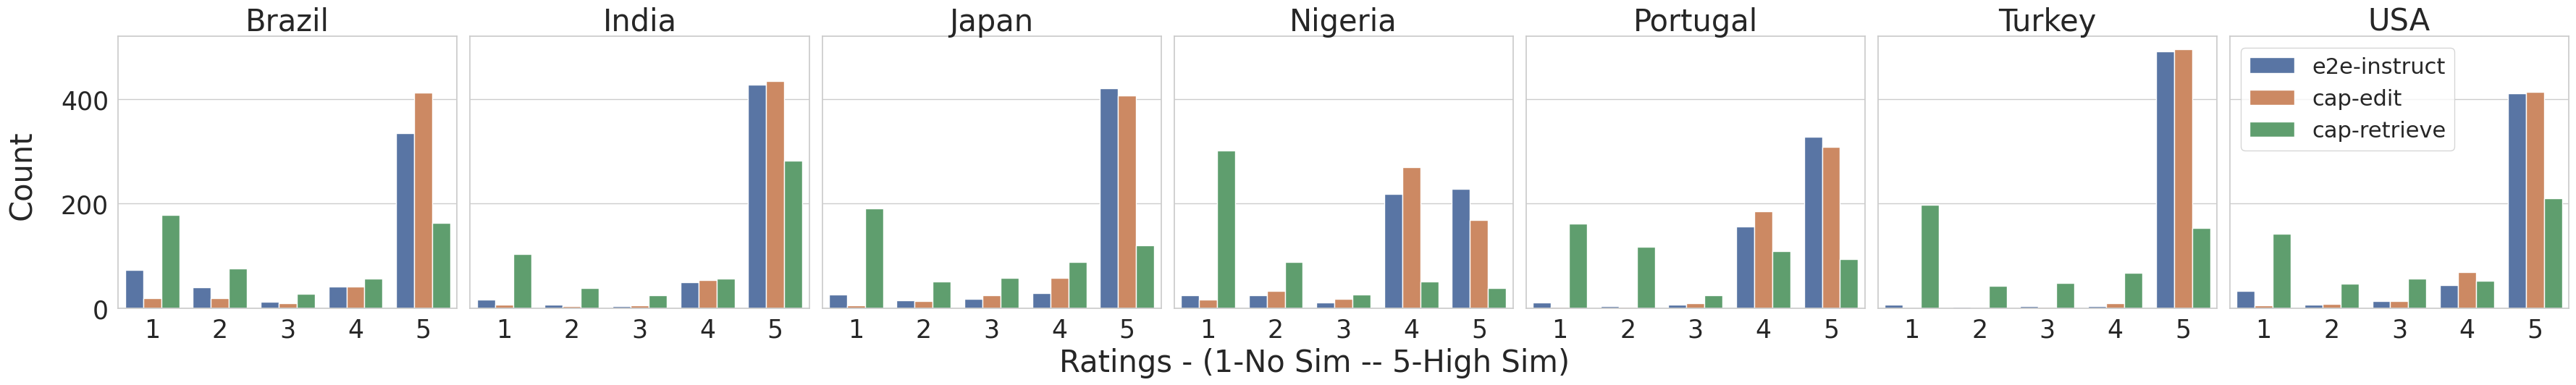

In [ ]:
sns.set(style="whitegrid")

# Assuming average_dicts is a list of dictionaries
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][1])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].set_title(titles[i], fontsize=font_size)  # Set individual title
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=22, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.02, 'Ratings'+' - (1-No Sim -- 5-High Sim)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Offensive Ratings - Q6

*This image is offensive to you, or is likely offensive to someone from your culture.*

*1 → not offensive; 5 → offensive*

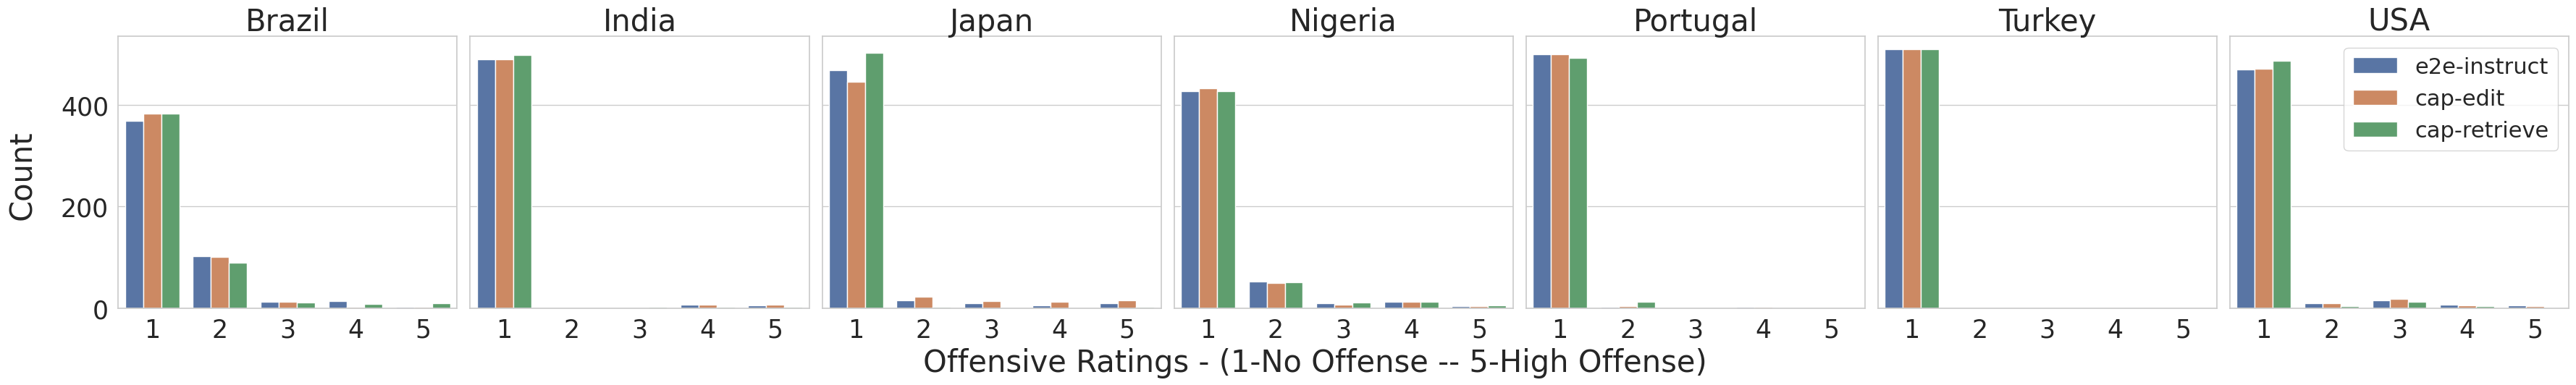

In [ ]:
sns.set(style="whitegrid")

# Assuming average_dicts is a list of dictionaries
# average_dicts = [...]  # Your list of 7 dictionaries
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries #['Title 1', 'Title 2', 'Title 3', 'Title 4', 'Title 5', 'Title 6', 'Title 7']

for i, country in enumerate(countries):

    # if country == 'brazil':
    #   continue

    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][5])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve', 'original']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].set_title(titles[i], fontsize=font_size)  # Set individual title
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=22, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.02, 'Offensive Ratings'+' - (1-No Offense -- 5-High Offense)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Fake or Real - Q4

*The image reflects naturally occurring scenes/objects (it does not look unnaturally edited and is something you can expect to see in the real world).*


*1 → unnatural; 5 → natural*

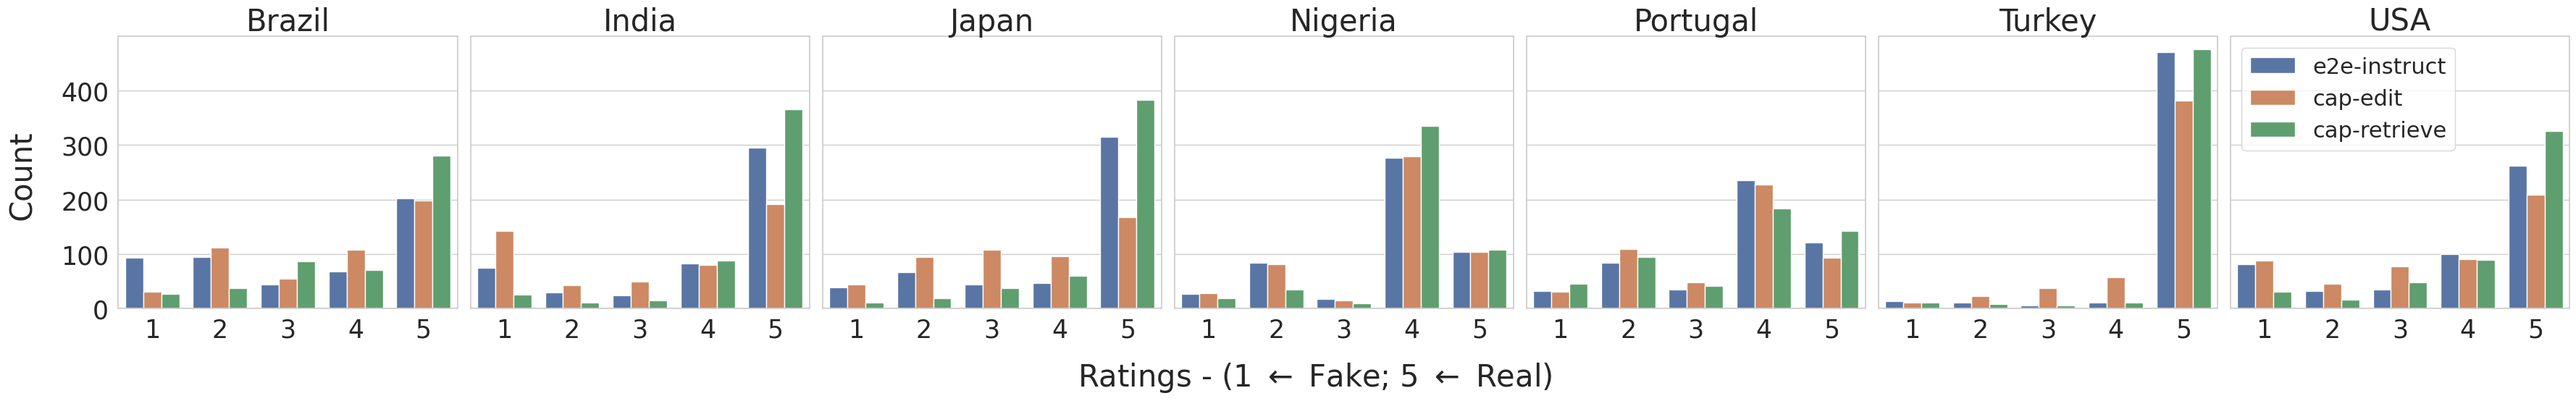

In [ ]:
sns.set(style="whitegrid")

# Assuming average_dicts is a list of dictionaries
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][3])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].set_title(good_title[titles[i]], fontsize=font_size)  # Set individual title
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=22, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.06, 'Ratings - (1 $\leftarrow$ Fake; 5 $\leftarrow$ Real)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Cultural Relevance - Q5 without filtering

*The image seems like it came from your country or is representative of your culture.*

*1 → not culturally relevant; 5 → culturally relevant*

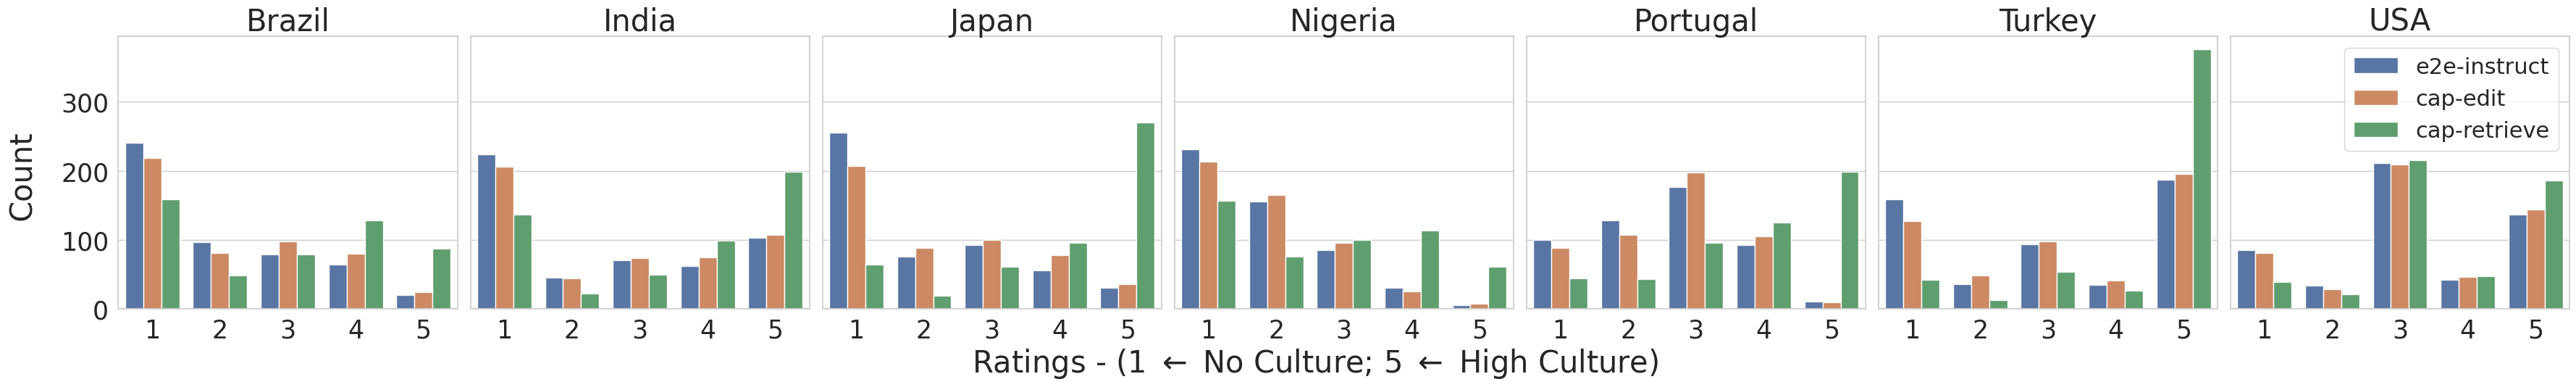

In [ ]:
sns.set(style="whitegrid")

# Assuming average_dicts is a list of dictionaries
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis

# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    class_df = pd.DataFrame(country_dicts[country][4])
    class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve', 'original']
    long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')

    # Create a count plot on the ith axis
    sns.countplot(data=long_df, x='Value', hue='Category', order=[1,2,3,4,5], ax=axes[i])
    axes[i].set_title(titles[i], fontsize=font_size)  # Set individual title
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
        axes[i].legend(title='', fontsize=22, title_fontsize=font_size)
    else:
        axes[i].legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.02, 'Ratings - (1 $\leftarrow$ No Culture; 5 $\leftarrow$ High Culture)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

## Semantic Meaning - Q2 with Q1 > 2  filtering

We check for images that have visual changes and observe how the semantic meanings vary


*1 → dissimilar category; 5 → same category*

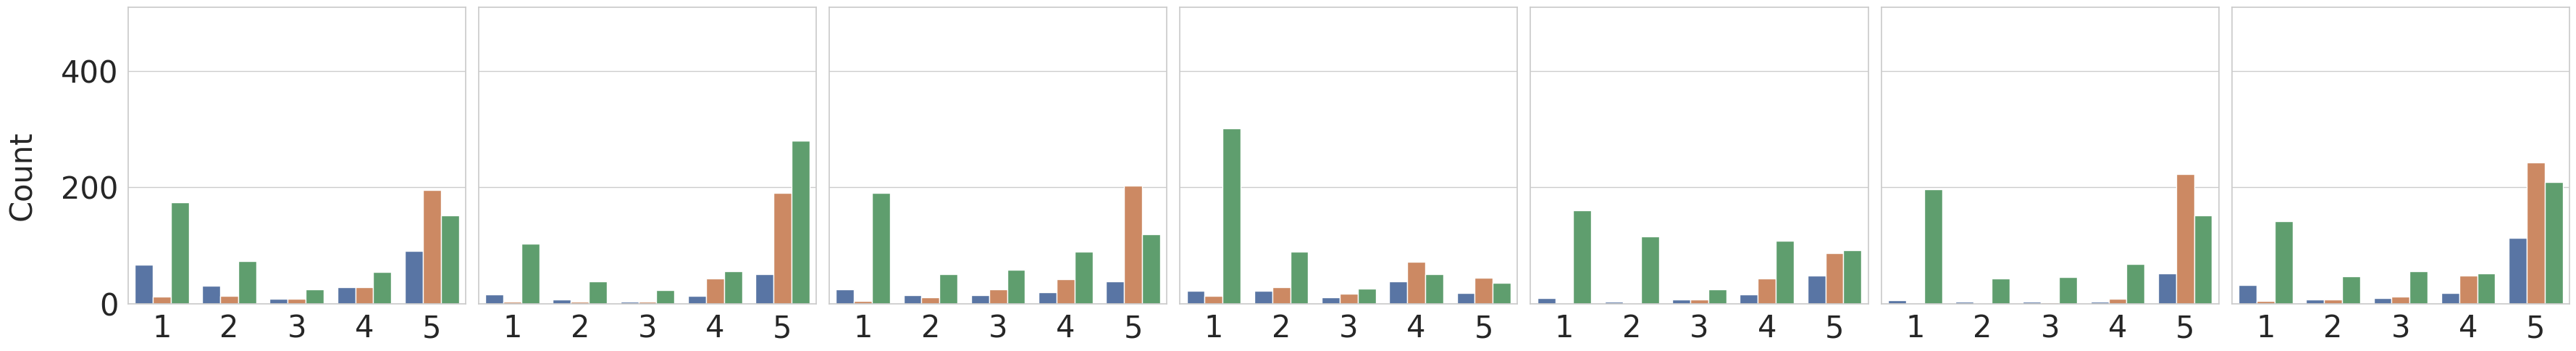

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

# Setting Seaborn style for aesthetics
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)
titles = countries

for idx, country in enumerate(countries):

  final_lists = defaultdict(list)

  for category in ['e2e-instruct', 'cap-edit', 'cap-retrieve']:# ['instruct', 'plugnplay', 'retrieval']:
      for val1, val2 in zip(country_dicts[country][1][category], country_dicts[country][0][category]):
          if val2 > 2:
              final_lists[category].append(val1)

  data = []
  for category, values in final_lists.items():
      for value in values:
          data.append({'Category': category, 'Value': value})
  long_df = pd.DataFrame(data)

  # Calculate the count of each value within each category
  value_counts = long_df.groupby(['Category', 'Value']).size().reset_index(name='Counts')

  # Calculate the total counts for each category to find percentages
  total_counts = long_df.groupby('Category').size().reset_index(name='TotalCounts')

  # Merge the counts with the total counts to calculate percentages
  merged_df = pd.merge(value_counts, total_counts, on='Category')
  merged_df['Percentage'] = (merged_df['Counts'] / merged_df['TotalCounts']) * 100

  font_size=30

  ax = axes[idx]
  sns.barplot(data=merged_df, x='Value', y='Counts', hue='Category', ax=ax, hue_order=['e2e-instruct', 'cap-edit', 'cap-retrieve'])


  # ax.set_title(good_title[titles[idx]], fontsize=font_size)  # Set individual title
  ax.tick_params(axis='x', labelsize=30)
  ax.tick_params(axis='y', labelsize=30)
  ax.set_xlabel('', fontsize=16)  # Remove x-axis label
  ax.set_ylabel('', fontsize=16)  # Remove y-axis label
  ax.set_ylim(bottom=0, top=510)
  ax.legend([],[], frameon=False)  # No legend for other subplots

fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()


## Cultural Relevance - Q5 with Q1>2 filtering

Similar to semantic meaning but on cultural relevance of each pipelines


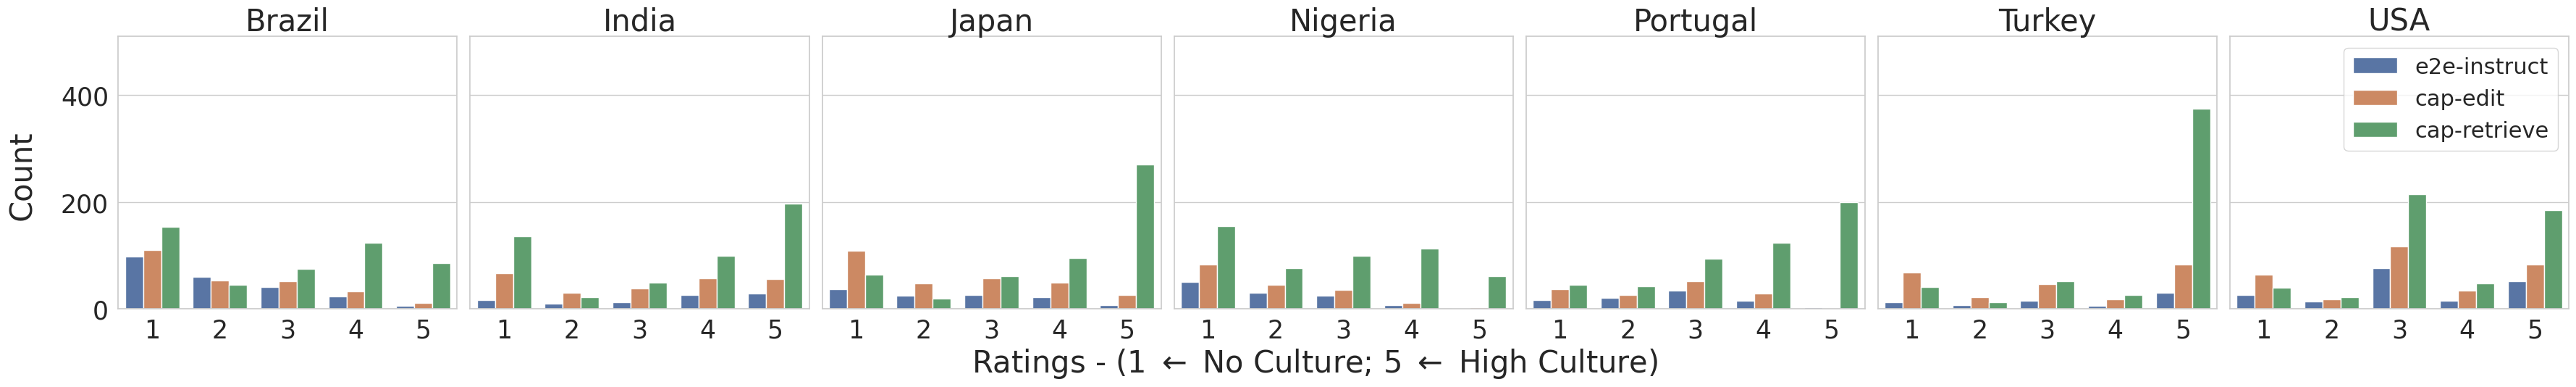

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

# Setting Seaborn style for aesthetics
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)
titles = countries

for idx, country in enumerate(countries):

  final_lists = defaultdict(list)

  for category in ['e2e-instruct', 'cap-edit', 'cap-retrieve']:#['instruct', 'plugnplay', 'retrieval']:
      for val1, val2 in zip(country_dicts[country][4][category], country_dicts[country][0][category]):
          if val2 > 2:
              final_lists[category].append(val1)

  data = []
  for category, values in final_lists.items():
      for value in values:
          data.append({'Category': category, 'Value': value})
  long_df = pd.DataFrame(data)
  # long_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']

  # Calculate the count of each value within each category
  value_counts = long_df.groupby(['Category', 'Value']).size().reset_index(name='Counts')

  # Calculate the total counts for each category to find percentages
  total_counts = long_df.groupby('Category').size().reset_index(name='TotalCounts')

  # Merge the counts with the total counts to calculate percentages
  merged_df = pd.merge(value_counts, total_counts, on='Category')
  merged_df['Percentage'] = (merged_df['Counts'] / merged_df['TotalCounts']) * 100

  font_size=30

  ax = axes[idx]
  sns.barplot(data=merged_df, x='Value', y='Counts', hue='Category', ax=ax, hue_order=['e2e-instruct', 'cap-edit', 'cap-retrieve'])


  ax.set_title(good_title[titles[idx]], fontsize=font_size)  # Set individual title
  ax.tick_params(axis='x', labelsize=25)
  ax.tick_params(axis='y', labelsize=25)
  ax.set_xlabel('', fontsize=16)  # Remove x-axis label
  ax.set_ylabel('', fontsize=16)  # Remove y-axis label
  ax.set_ylim(bottom=0, top=510)


  if idx == 6:
      ax.legend(title='', fontsize=22, title_fontsize=font_size)
  else:
      ax.legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.02, 'Ratings - (1 $\leftarrow$ No Culture; 5 $\leftarrow$ High Culture)', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()


## Cultural Relevance

Expressing with delta values mentioning positive and negative influences



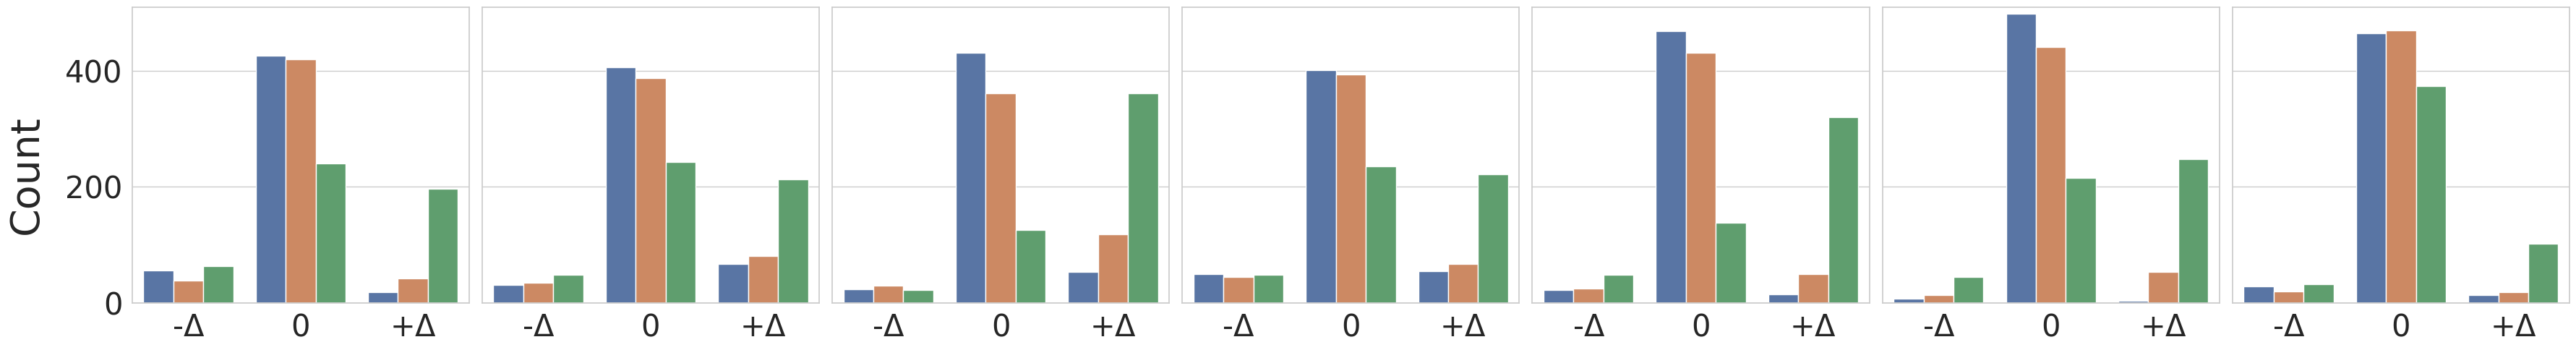

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

# Setting Seaborn style for aesthetics
sns.set(style="whitegrid")


fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)
titles = countries

for idx, country in enumerate(countries):


  class_dict_q4 = {
      'e2e-instruct': diff_dicts[country]['e2e-instruct'],
      'cap-edit': diff_dicts[country]['cap-edit'],
      'cap-retrieve': diff_dicts[country]['cap-retrieve']
  }


  class_df = pd.DataFrame(class_dict_q4)
  class_df.columns = ['e2e-instruct', 'cap-edit', 'cap-retrieve']

  # Reshape the DataFrame to long format
  long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')
  long_df.replace([1, 2, 3, 4], '+$\Delta$', inplace=True)
  long_df.replace([-1], '-$\Delta$', inplace=True)


  font_size=40


  # Customizing the plot
  # plt.figure(figsize=(20, 15))
  ax = axes[idx]

  sns.countplot(data=long_df, x='Value', hue='Category', order=['-$\Delta$',0,'+$\Delta$'], ax=ax)

  # ax.set_title(good_title[titles[idx]], fontsize=font_size)  # Set individual title
  ax.tick_params(axis='x', labelsize=30)
  ax.tick_params(axis='y', labelsize=30)
  ax.set_xlabel('', fontsize=16)  # Remove x-axis label
  ax.set_ylabel('', fontsize=16)  # Remove y-axis label
  ax.set_ylim(bottom=0, top=510)


  if idx == 7:
      ax.legend(title='', fontsize=22, title_fontsize=font_size)
  else:
      ax.legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()


## C1 + C3

Count of the influence of visually and semantically relevant images on culture

In [26]:
def filter_values(list1, list2, list3, list4):

    matching_indices = []

    for i in range(len(list1)):

        if int(list1[i]) > 2 and int(list2[i]) > 3 and int(list3[i] - list4[i])>0:
            matching_indices.append(i)

    return matching_indices


<ipython-input-27-2ed16825d6e5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


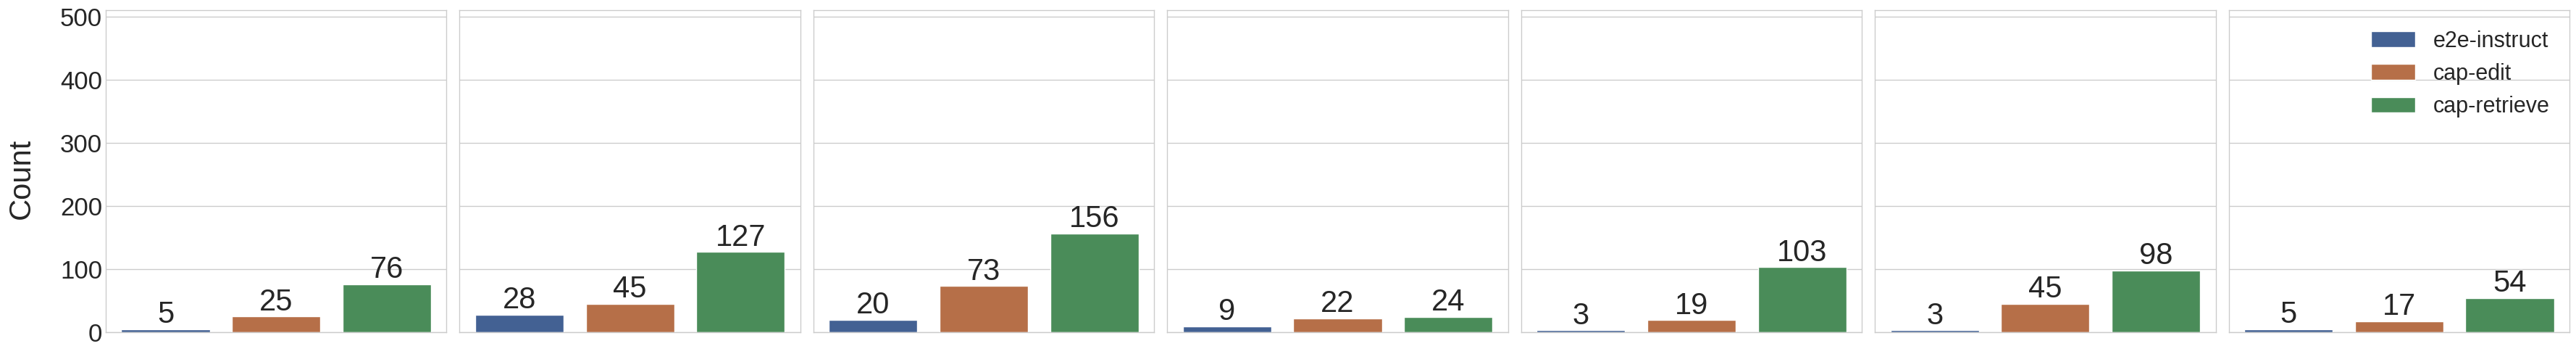

In [27]:
# sns.set(style="whitegrid")
plt.style.use('seaborn-whitegrid')
colors = sns.color_palette()[:3]
darker_colors = [sns.dark_palette(color, n_colors=10)[7] for color in colors]
font_size = 30
# Define the size of the entire figure
fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)  # 7 subplots in a row, sharing y-axis
# Titles for each subplot
titles = countries

for i, country in enumerate(countries):
    # Convert the current dictionary to a DataFrame and then to long format
    indices_instruct = filter_values(country_dicts[country][0]['e2e-instruct'], country_dicts[country][1]['e2e-instruct'], country_dicts[country][4]['e2e-instruct'], country_dicts[country][4]['original'])

    indices_plugnplay = filter_values(country_dicts[country][0]['cap-edit'], country_dicts[country][1]['cap-edit'], country_dicts[country][4]['cap-edit'], country_dicts[country][4]['original'])

    indices_retrieval = filter_values(country_dicts[country][0]['cap-retrieve'], country_dicts[country][1]['cap-retrieve'], country_dicts[country][4]['cap-retrieve'], country_dicts[country][4]['original'])



    # Your data
    values = [len(indices_instruct), len(indices_plugnplay), len(indices_retrieval)]  # These are the counts for each label
    labels = ['e2e-instruct', 'cap-edit', 'cap-retrieve']

    bars = axes[i].bar(labels, values, color=darker_colors)
    axes[i].tick_params(axis='x', labelsize=25)
    axes[i].set_xticks([])
    axes[i].tick_params(axis='y', labelsize=25)
    axes[i].set_xlabel('', fontsize=16)  # Remove x-axis label
    axes[i].set_ylabel('', fontsize=16)  # Remove y-axis label
    axes[idx].set_ylim(0,510)
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=30)

    # Only add legend to the first subplot to avoid repetition
    if i == 6:
      axes[i].legend(bars, labels, title='', fontsize=22, title_fontsize=font_size)
    else:
      axes[i].legend([],[], frameon=False)  # No legend for other subplots

fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()

# PART-2

Analysis for application dataset

In [9]:
countries

['Brazil', 'India', 'Japan', 'Nigeria', 'Portugal', 'Turkey', 'USA']

In [10]:
def get_dicts_scores(df1, df2, gold_labels, q1=False):

  q1_df1 = df1.replace({'[a-z\(\)\s]': ''}, regex=True) # Remove unneccessary text
  # q1_df1.index = q1_df1.index - 2 # Reindex
  if q1:
    q1_df1.columns = ['1','2', '3', '4'] # Replace column names with Image Numbers
  else:
    q1_df1.columns = ['2', '3', '4']
  # q1_df1.head()

  q1_df2 = df2.replace({'[a-z\(\)\s]': ''}, regex=True) # Remove unneccessary text
  # q1_df2.index = q1_df2.index - 2 # Reindex
  if q1:
    q1_df2.columns = ['1','2', '3', '4'] # Replace column names with Image Numbers
  else:
    q1_df2.columns = ['2', '3', '4']

  if q1:

    class_dict_1_df1 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df1.keys():
        class_dict_1_df1[label].extend(q1_df1.iloc[:,1:][gold_labels == label].stack().values)

    class_dict_1_df2 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df2.keys():
        class_dict_1_df2[label].extend(q1_df2.iloc[:,1:][gold_labels == label].stack().values)

    class_dict_1_df1['original'] = q1_df1.iloc[:,0].values
    class_dict_1_df2['original'] = q1_df2.iloc[:,0].values

  else:

    class_dict_1_df1 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df1.keys():
        class_dict_1_df1[label].extend(q1_df1[gold_labels == label].stack().values)

    class_dict_1_df2 = {'e2e-instruct': [], 'cap-edit': [], 'cap-retrieve': []}
    for label in class_dict_1_df2.keys():
        class_dict_1_df2[label].extend(q1_df2[gold_labels == label].stack().values)

  return class_dict_1_df1, class_dict_1_df2

In [17]:
# Merge 5 split csvs into one dataframe. This is for one annotator


def merge_country_splits_part2(Country):

  # Initialize lists to hold dataframes for concatenation
  all_df1 = []
  all_gold_df = []
  all_gold_df_temp = []

  # Loop over the 5 splits
  for split_num in range(1, 2):
      # Adjust the file paths for each split
      split_filename = f'/content/drive/MyDrive/image-transcreation/part3-image_assessment/{Country}/part2.csv'
      label_filename = f'/content/drive/MyDrive/image-transcreation/part3-image_assessment/labels/part2/{Country}/split_1.csv'

      # Read the data
      df1 = pd.read_csv(split_filename)
      gold_df = pd.read_csv(label_filename)

      # Process df1
      df1 = df1.loc[2:].reset_index(drop=True)

      # Process df1 for questions, assuming similar processing as before
      df1 = df1.iloc[2:,:11]
      df1.index = df1.index - 2
      df1 = df1.head(len(gold_df))

      if gold_df.shape[0]>df1.shape[0]:
        gold_df = gold_df.head(len(df1))

      # Create and apply the boolean mask
      mask = df1.isna().any(axis=1)
      df1_filtered = df1[~mask]

      gold_df = gold_df[~mask]

      # Process gold_labels from gold_df
      gold_labels = gold_df.iloc[:,5:8]
      gold_labels.columns = ['2','3','4']

      df1_filtered.columns = [str(x) for x in range(len(df1_filtered.columns))]

      all_df1.append(df1_filtered)
      all_gold_df.append(gold_labels)

  # Concatenate all dataframes in each list
  concatenated_df1 = pd.concat(all_df1, ignore_index=True)
  concatenated_gold_df = pd.concat(all_gold_df, ignore_index=True)


  return (concatenated_df1, concatenated_gold_df)



In [18]:

idxs = [(1,4), (4,7), (7,11)]

country_dicts = {}
diff_dicts = {}
final_sim_dict = {}

for idx, country in enumerate(countries):


  col_idx = 8


  df1, gold_labels =  merge_country_splits_part2(country)
  df2, gold_labels =  merge_country_splits_part2(country)


  # print(country, df1.shape, df2.shape, gold_labels.shape)

  average_dicts = []
  sim_dicts = []
  q2_1 = []
  q2_2 = []
  sim_vals = []
  diff_dict = {}

  q2_1_dict = {}
  q2_2_dict = {}

  for q_idx in range(3):


    q1_label = False

    if q_idx not in [0,1]:
      q1_label = True

    # print()

    sim_scores = {}

    df1_dict, df2_dict = get_dicts_scores(df1.iloc[:, idxs[q_idx][0]:idxs[q_idx][1]], df2.iloc[:, idxs[q_idx][0]:idxs[q_idx][1]], gold_labels, q1_label)

    average_dict = {}
    sim_dict = {}

    for key in df1_dict:
        # print(key)
        avg_values = []
        q2_1 = []
        q2_2 = []
        sim_vals = []
        for df_idx, (val1, val2) in enumerate(zip(df1_dict[key], df2_dict[key])):
          if np.isnan(float(val1)) and np.isnan(float(val2)):
            continue
          elif np.isnan(float(val1)):
            avg_values.append(int(val2))
          elif np.isnan(float(val2)):
            avg_values.append(int(val1))
          else:
            avg_values.append(int(np.floor(np.mean([int(val1), int(val2)]))))

            if q_idx==2:
              q2_1.append(max(int(val1)-int(df1_dict['original'][df_idx]),-1)) # Difference with Original Value
              q2_2.append(max(int(val2)-int(df2_dict['original'][df_idx]),-1))

        if q_idx==2:
          q2_1_dict[key] = q2_1
          q2_2_dict[key] = q2_2

        average_dict[key] = avg_values


    average_dicts.append(average_dict)

  for key in q2_1_dict.keys(): # For cultural relevance difference
    diff_dict[key] = [int(np.floor(np.mean([x,y]))) for x,y in zip(q2_1_dict[key],q2_2_dict[key])]


  diff_dicts[country] = diff_dict
  country_dicts[country] = average_dicts



## Q2 - With delta values

*The image matches or goes along with the task of the math worksheet or the title of the story.*

*1 → does not match; 5 → highly matches*

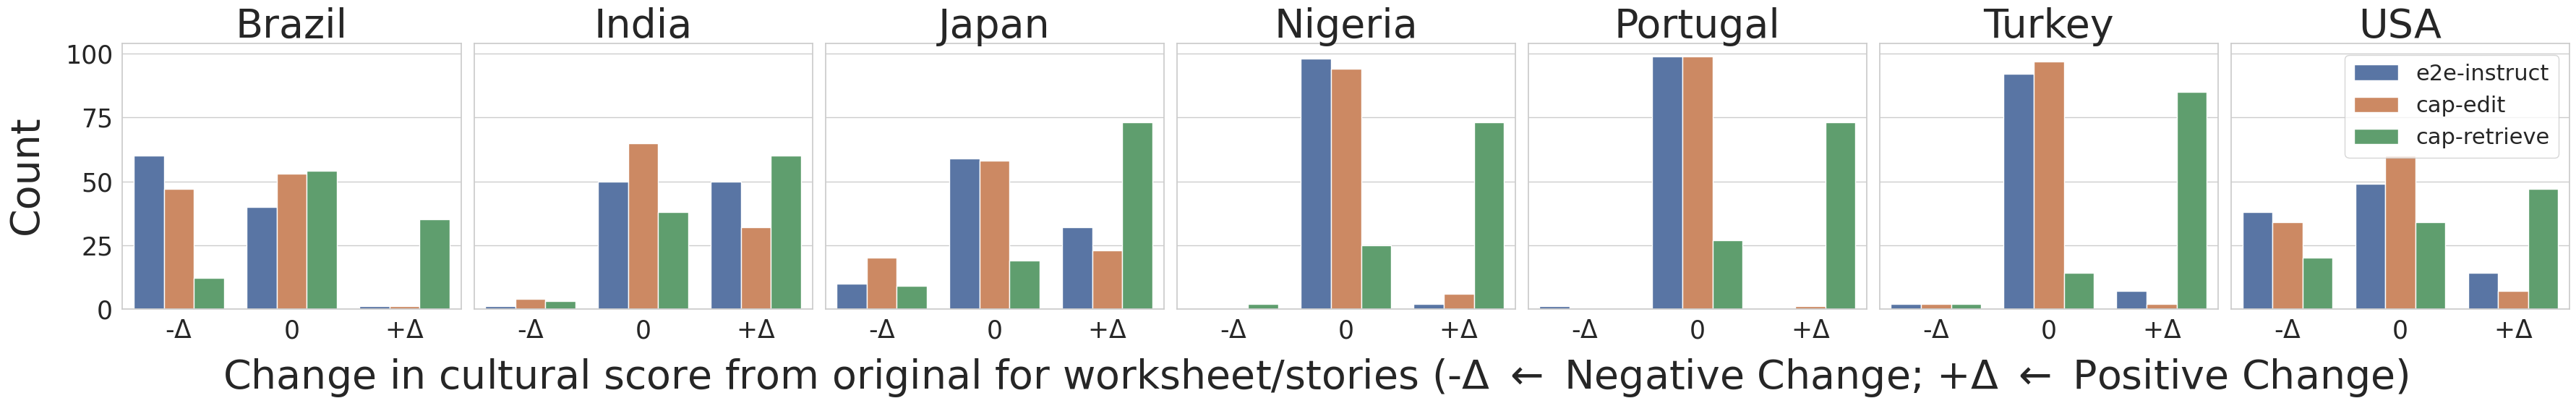

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

# Setting Seaborn style for aesthetics
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 7, figsize=(35, 5), sharey=True)
titles = countries

for idx, country in enumerate(countries):


  class_dict_q4 = {
      'e2e-instruct': diff_dicts[country]['e2e-instruct'],
      'cap-edit': diff_dicts[country]['cap-edit'],
      'cap-retrieve': diff_dicts[country]['cap-retrieve']
  }


  class_df = pd.DataFrame(class_dict_q4)

  # Reshape the DataFrame to long format
  long_df = pd.melt(class_df, value_vars=['e2e-instruct', 'cap-edit', 'cap-retrieve'], var_name='Category', value_name='Value')
  long_df.replace([1, 2, 3, 4], '+$\Delta$', inplace=True)
  long_df.replace([-1], '-$\Delta$', inplace=True)

  font_size=40


  # Customizing the plot
  ax = axes[idx]

  sns.countplot(data=long_df, x='Value', hue='Category', order=['-$\Delta$',0,'+$\Delta$'], ax=ax)

  ax.set_title(good_title[titles[idx]], fontsize=font_size)  # Set individual title
  ax.tick_params(axis='x', labelsize=25)
  ax.tick_params(axis='y', labelsize=25)
  ax.set_xlabel('', fontsize=16)  # Remove x-axis label
  ax.set_ylabel('', fontsize=16)  # Remove y-axis label


  if idx == 6:
      ax.legend(title='', fontsize=22, title_fontsize=font_size)
  else:
      ax.legend([],[], frameon=False)  # No legend for other subplots

# Set common labels
fig.text(0.5, -0.06, 'Change in cultural score from original for worksheet/stories (-$\Delta$ $\leftarrow$ Negative Change; +$\Delta$ $\leftarrow$ Positive Change) ', ha='center', va='center', fontsize=font_size)
fig.text(-0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=font_size)

plt.tight_layout()
plt.show()
